In [117]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import FastICA, PCA
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from sklearn.svm import SVC
import copy
import glob
from padelpy import from_smiles
from autorank import autorank, create_report

from Imitate import Imitate
from Mimic import *
from Multilabel import *

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [2]:
COLORS = {'SOIL': '#004488',
         'BBD': '#882255',
         'tr': '#BBBBBB',
         'imi': '#DDAA33',
         'bias': '#BB5566',
         'val': '#000000'}
COLNAMES = {'SOIL': 'blue', 'BBD': 'wine', 'imi': 'yellow'}
CMAPS = {'imi': matplotlib.colors.LinearSegmentedColormap.from_list("", [COLORS['imi'], 'white'], N=256),
        'SOIL': matplotlib.colors.LinearSegmentedColormap.from_list("", [COLORS['SOIL'], 'white'], N=256),
        'BBD': matplotlib.colors.LinearSegmentedColormap.from_list("", [COLORS['BBD'], 'white'], N=256),
        'SOIL_bi': matplotlib.colors.LinearSegmentedColormap.from_list("", ['#88CCEE', COLORS['SOIL'], '#000000'], N=256),
        'BBD_bi': matplotlib.colors.LinearSegmentedColormap.from_list("", ['#EE99AA', COLORS['BBD'], '#000000'], N=256)}

In [3]:
def approxKDE(g, h, n=1000): # grid and heights
    g = np.array(g)
    resamples = np.random.choice((g[:-1]+g[1:])/2, size=n, p=h/h.sum())
    return gaussian_kde(resamples)

# Sample & Correct

Mitigating the bias might or might not have a positive impact on downstream tasks like classification. To investigate, we set up an experiment as follows: 

- split dataset into training, validation, and test set.
- apply CANCELS on the training set and see where we need to fill data in
- select the best suited points from the validation set (sample points based on a score and add until the likelihood of the model given the data saturates)
- compare the test accuracy of multilabel classifiers for reaction prediction trained on (i) training only, (ii) training + CANCELS, (iii) training + validation

# Single Iteration on Tox21

In [13]:
def run_exp(data, labels, 
            test_size=0.2, val_size=0.2, 
            batchsize=10, num_restarts=3, 
            num_ica=5, repeat=100,
            boundaries=False, strength=1):
    
    res = np.zeros((repeat, 4))
    res_hd = np.zeros((repeat, 4))
    res_ld = np.zeros((repeat, 4))
    for r in range(77, 100):#repeat):
        # train ica, split data, train Imitate
        ica = FastICA(n_components = num_ica)
        tr, test, idcs_tr, idcs_test = train_test_split(data, np.arange(len(data)), test_size=test_size)
        tr, val, idcs_tr, idcs_val = train_test_split(tr, idcs_tr, test_size=val_size)
        ica.fit(tr)
        d = ica.transform(tr)
        
        # split test into high and low density regions
        kde = gaussian_kde(d.T)
        kde_vals = kde.evaluate(ica.transform(test).T)
        threshold = np.median(kde_vals)
        high_density_idcs = kde_vals >= threshold
        test_hd, idcs_test_hd = test[high_density_idcs], idcs_test[high_density_idcs]
        test_ld, idcs_test_ld = test[~high_density_idcs], idcs_test[~high_density_idcs]

        if boundaries:
            bounds_trf = np.vstack((d.min(axis=0), d.max(axis=0))).transpose()
            range_trf = bounds_trf[:,1] - bounds_trf[:,0]
            bounds_relaxed = np.vstack((bounds_trf[:,0]-0.1*range_trf, bounds_trf[:,1]+0.1*range_trf)).transpose()
            grids, vals, fitted, fill_up, num_fill_up, scale, mean, cov = Imitate(d, plots=False, bounds=bounds_relaxed, strength=strength)
        else:
            grids, vals, fitted, fill_up, num_fill_up, scale, mean, cov = Imitate(d, plots=False, strength=strength)

        # select leftout points that improve the bias
        score = mimic_score(ica.transform(val), grids, vals, fitted, fill_up, vals_only=False)
        score = score / np.sum(score)  #convert to probability distribution
        score_b = mimic_score(ica.transform(val), grids, vals, fitted, fill_up, vals_only=True)
        score_b = score_b / np.sum(score_b)  #convert to probability distribution

        idcs = add_points(d, grids, fitted, num_fill_up, score, ica.transform(val), 
                          batchsize=batchsize, num_restarts=num_restarts)
        idcs_b = add_points(d, grids, fitted, num_fill_up, score_b, ica.transform(val), 
                          batchsize=batchsize, num_restarts=num_restarts)

        X, Y = data[idcs_tr], labels[idcs_tr]
        X_plus, Y_plus = data[np.append(idcs_tr, idcs)], labels[np.append(idcs_tr, idcs)]
        X_bias, Y_bias = data[np.append(idcs_tr, idcs_b)], labels[np.append(idcs_tr, idcs_b)]
        X_full, Y_full = data[np.append(idcs_tr, idcs_val)], labels[np.append(idcs_tr, idcs_val)]
        X_test, Y_test = data[idcs_test], labels[idcs_test]
        X_test_hd, Y_test_hd = data[idcs_test_hd], labels[idcs_test_hd]
        X_test_ld, Y_test_ld = data[idcs_test_ld], labels[idcs_test_ld]

        # Classifier Chains
        cc = EnsembleClassifierChain(SVC(probability=True))
        #cc = ClassifierChain(SVC(probability=True))
        cc.fit(X, Y)
        res[r, 0] =  hamming_accuracy(Y_test, cc.predict(X_test))
        res_hd[r, 0] =  hamming_accuracy(Y_test_hd, cc.predict(X_test_hd))
        res_ld[r, 0] =  hamming_accuracy(Y_test_ld, cc.predict(X_test_ld))
        cc.fit(X_plus, Y_plus)
        res[r, 1] = hamming_accuracy(Y_test, cc.predict(X_test))
        res_hd[r, 1] =  hamming_accuracy(Y_test_hd, cc.predict(X_test_hd))
        res_ld[r, 1] =  hamming_accuracy(Y_test_ld, cc.predict(X_test_ld))
        cc.fit(X_bias, Y_bias)
        res[r, 2] = hamming_accuracy(Y_test, cc.predict(X_test))
        res_hd[r, 2] =  hamming_accuracy(Y_test_hd, cc.predict(X_test_hd))
        res_ld[r, 2] =  hamming_accuracy(Y_test_ld, cc.predict(X_test_ld))
        cc.fit(X_full, Y_full)
        res[r, 3] = hamming_accuracy(Y_test, cc.predict(X_test))
        res_hd[r, 3] =  hamming_accuracy(Y_test_hd, cc.predict(X_test_hd))
        res_ld[r, 3] =  hamming_accuracy(Y_test_ld, cc.predict(X_test_ld))
        
        np.savetxt('Results\\Tox_NEW_it_'+str(r)+'.npy', [res[r], res_hd[r], res_ld[r]])
    return res, res_hd, res_ld

In [4]:
df = pd.read_csv('Data/Tox21_MACCS.csv', header=0, low_memory=False)
cols = df.columns
d = df.replace('?', np.nan).astype(float).to_numpy()
tox_X, tox_Y = d[:,['y' not in col for col in cols]], d[:,['y' in col for col in cols]]

C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


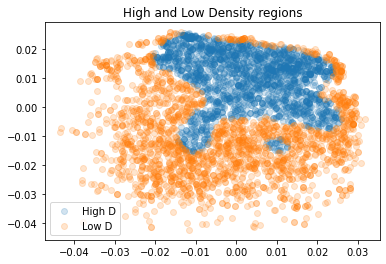

In [6]:
# high and low density regions
ica = FastICA(n_components = 2)
tr, test, idcs_tr, idcs_test = train_test_split(tox_X, np.arange(len(tox_X)), test_size=0.4)
tr, val, idcs_tr, idcs_val = train_test_split(tr, idcs_tr, test_size=0.4)
ica.fit(tr)
d = ica.transform(tr)
        
# split test into high and low density regions
kde = gaussian_kde(d.T)
kde_vals = kde.evaluate(ica.transform(test).T)
threshold = np.median(kde_vals)
high_density_idcs = kde_vals >= threshold
test_hd, idcs_test_hd = test[high_density_idcs], idcs_test[high_density_idcs]
test_ld, idcs_test_ld = test[~high_density_idcs], idcs_test[~high_density_idcs]
hd, ld = ica.transform(test_hd), ica.transform(test_ld)

plt.scatter(hd[:,0], hd[:,1], label='High D', alpha=0.2)
plt.scatter(ld[:,0], ld[:,1], label='Low D', alpha=0.2)
plt.title('High and Low Density regions')
plt.legend()
plt.show()

In [15]:
# res_tox_new_ecc = run_exp(tox_X, tox_Y, test_size=0.4, val_size=0.4, batchsize=10, num_restarts=3, num_ica=5, repeat=100, 
#                boundaries=True, strength=1000)

In [169]:
files = glob.glob('Results\\Tox_NEW*')
res, res_hd, res_ld = np.empty((0,4)), np.empty((0,4)), np.empty((0,4))
for f in files:
    a = np.loadtxt(f)
    res = np.row_stack((res, [a[0]]))
    res_hd = np.row_stack((res_hd, [a[1]]))
    res_ld = np.row_stack((res_ld, [a[2]]))
res_tox_new_ecc = [res, res_hd, res_ld]

#### Significance of the results

In [120]:
df = pd.DataFrame(res_tox_new_ecc[0], columns=['CLF trained on Training Set (Tr)', 'Tr + CANCELS', 'Tr + High Density Points', 'Tr + Entire Pool'])
res = autorank(df, alpha=0.01)
create_report(res)

The statistical analysis was conducted for 4 populations with 100 paired samples.
The family-wise significance level of the tests is alpha=0.010.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.217). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.528) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confi

#### Plots

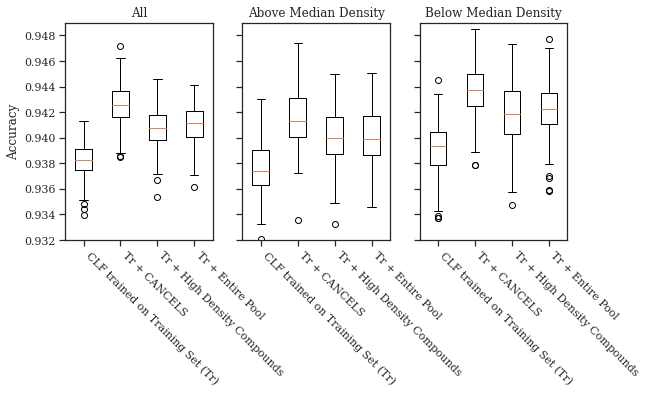

In [123]:
sns.set_style("ticks")
plt.rc('font', family='serif')
fig, ax = plt.subplots(1, 3, figsize=(9,4), sharey=True)
labels = ['All', 'Above Median Density', 'Below Median Density']
for i in range(3):
    ax[i].boxplot(res_tox_new_ecc[i])
    ax[i].set_title(labels[i])
    ax[i].set_ylim([0.932, 0.949])
    #ax[i].set_xlabel('Classifier trained on')
    ax[i].set_xticklabels(['CLF trained on Training Set (Tr)', 'Tr + CANCELS', 'Tr + High Density Compounds', 'Tr + Entire Pool'], 
                          rotation=315, ha='left')
ax[0].set_ylabel('Accuracy')
plt.show()

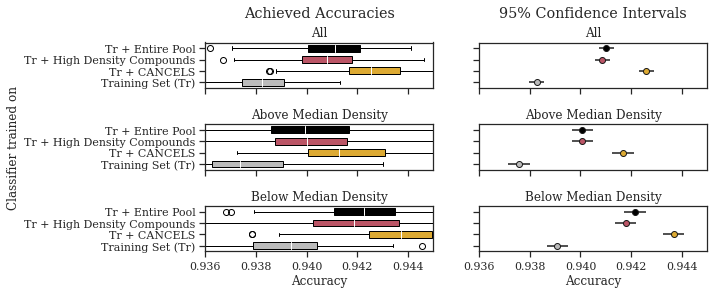

In [185]:
cs = [COLORS['tr'], COLORS['imi'], COLORS['bias'], COLORS['val']]
sns.set_style("ticks")
plt.rc('font', family='serif')
fig, ax = plt.subplots(3, 2, figsize=(9,4), sharex=True, sharey=False)
fig.subplots_adjust(hspace=0.8, top=0.85)

ax[0,0].annotate('Achieved Accuracies', xy=(0.5,1), xytext=(0, 25),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
labels = ['All', 'Above Median Density', 'Below Median Density']
trained_on = ['Training Set (Tr)', 'Tr + CANCELS', 'Tr + High Density Compounds', 'Tr + Entire Pool']
for i in range(3):
    bp = ax[i,0].boxplot(res_tox_new_ecc[i], vert=False, patch_artist=True, widths=0.6)
    ax[i,0].set_title(labels[i])
    ax[i,0].set_xlim([0.932, 0.949])
    ax[i,0].set_yticklabels(trained_on)
    for patch, color in zip(bp['boxes'], cs):
        patch.set_facecolor(color)
    plt.setp(bp['medians'], color='white')
ax[1,0].set_ylabel('Classifier trained on')
ax[2,0].set_xlabel('Accuracy')

# handmade autorank plot
ax[0,1].annotate('95% Confidence Intervals', xy=(0.5,1), xytext=(0, 25),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
for i in range(3):
    ar = autorank(pd.DataFrame(res_tox_new_ecc[i], columns=['B', 'B+_debias', 'B+_bias', 'B_full']))   
    df = pd.DataFrame(ar[0], columns=['mean', 'ci_upper', 'ci_lower'], index=['B', 'B+_debias', 'B+_bias', 'B_full'])
    #plot_stats(ar, ax=ax[i])
    for j in range(len(df['mean'])):
        ax[i,1].errorbar(df['mean'][j], j, xerr=(df.ci_upper[j] - df.ci_lower[j])/2,
                      linestyle='None', ecolor='k', marker='o', markerfacecolor=cs[j], markeredgecolor='k')
    
    ax[i,1].set_title(labels[i])
    ax[i,1].set_xlim([0.936, 0.945])
    ax[i,1].set_yticks([0,1,2,3])
    ax[i,1].set_ylim([-0.5, 3.5])
    ax[i,1].set_yticklabels([])
ax[2,1].set_xlabel('Accuracy')

plt.savefig('Plots/Bias_or_Debias_Tox_combined.pdf', bbox_inches='tight')
plt.show()

# Iterative application of CANCELS: What's the long-term benefit?

In [13]:
def run_exp_iter(data, labels, 
            batchsize=10, num_restarts=3, 
            num_ica=5, num_iters=5, repeat=100,
            boundaries=False, strength=1):
    
    l = len(data)
    splits = np.append([.2*l], [.2*l + (i+1)*.4*l/num_iters for i in range(num_iters)]).astype(int)
    for r in range(repeat):
        # train ica, split data, train Imitate
        ica_mimic = FastICA(n_components = num_ica)
        ica_b = FastICA(n_components = num_ica)
        idcs = np.arange(len(data))
        np.random.shuffle(idcs)
        idcs = np.split(idcs, splits)
        tr, idcs_tr = data[idcs[0], :], idcs[0]
        test, idcs_test = data[idcs[-1], :], idcs[-1]
        
        # split test into high and low density regions
        ica_mimic.fit(tr)
        kde = gaussian_kde(ica_mimic.transform(tr).T)
        kde_vals = kde.evaluate(ica_mimic.transform(test).T)
        threshold = np.median(kde_vals)
        high_density_idcs = kde_vals >= threshold
        test_hd, idcs_test_hd = test[high_density_idcs], idcs_test[high_density_idcs]
        test_ld, idcs_test_ld = test[~high_density_idcs], idcs_test[~high_density_idcs]
        
        idcs_mimic_all = copy.deepcopy(idcs_tr)
        idcs_b_all = copy.deepcopy(idcs_tr)
        idcs_tr_all = copy.deepcopy(idcs_tr)
        idcs_val_all = copy.deepcopy(idcs_tr)
        
        for i in range(num_iters):
            val, idcs_val = data[idcs[1+i], :], idcs[1+i]
            ica_mimic.fit(data[idcs_mimic_all])
            ica_b.fit(data[idcs_b_all])
            d_mimic = ica_mimic.transform(data[idcs_mimic_all])
            d_b = ica_b.transform(data[idcs_b_all])
        
            bounds_trf = np.vstack((d_mimic.min(axis=0), d_mimic.max(axis=0))).transpose()
            range_trf = bounds_trf[:,1] - bounds_trf[:,0]
            bounds_relaxed = np.vstack((bounds_trf[:,0]-0.1*range_trf, bounds_trf[:,1]+0.1*range_trf)).transpose()
            grids, vals, fitted, fill_up, num_fill_up, scale, mean, cov = Imitate(d_mimic, plots=False, bounds=bounds_relaxed, strength=strength)
            # select leftout points that improve the bias
            score = mimic_score(ica_mimic.transform(val), grids, vals, fitted, fill_up, vals_only=False)
            score = score / np.sum(score)  #convert to probability distribution
            idcs_mimic = add_points(d_mimic, grids, fitted, num_fill_up, score, ica_mimic.transform(val), 
                                    batchsize=batchsize, num_restarts=num_restarts)
            
            bounds_trf = np.vstack((d_b.min(axis=0), d_b.max(axis=0))).transpose()
            range_trf = bounds_trf[:,1] - bounds_trf[:,0]
            bounds_relaxed = np.vstack((bounds_trf[:,0]-0.1*range_trf, bounds_trf[:,1]+0.1*range_trf)).transpose()
            grids, vals, fitted, fill_up, num_fill_up, scale, mean, cov = Imitate(d_b, plots=False, bounds=bounds_relaxed, strength=strength)
            score_b = mimic_score(ica_b.transform(val), grids, vals, fitted, fill_up, vals_only=True)
            score_b = score_b / np.sum(score_b)  #convert to probability distribution
            idcs_b = add_points(d_b, grids, fitted, num_fill_up, score_b, ica_b.transform(val), 
                              batchsize=batchsize, num_restarts=num_restarts)

            idcs_tr_all = copy.deepcopy(idcs_val_all)
            idcs_val_all = np.append(idcs_val_all, idcs_val)
            idcs_mimic_all = np.append(idcs_mimic_all, idcs_mimic)
            idcs_b_all = np.append(idcs_b_all, idcs_b)

            X_test, Y_test = data[idcs_test], labels[idcs_test]
            X_test_hd, Y_test_hd = data[idcs_test_hd], labels[idcs_test_hd]
            X_test_ld, Y_test_ld = data[idcs_test_ld], labels[idcs_test_ld]

            # Classifier Chains
            cc = EnsembleClassifierChain(SVC(probability=True))
            res, res_hd, res_ld = np.zeros(4), np.zeros(4), np.zeros(4)
            
            cc.fit(data[idcs_tr_all], labels[idcs_tr_all])
            res[0] =  hamming_accuracy(Y_test, cc.predict(X_test))
            res_hd[0] =  hamming_accuracy(Y_test_hd, cc.predict(X_test_hd))
            res_ld[0] =  hamming_accuracy(Y_test_ld, cc.predict(X_test_ld))
            cc.fit(data[idcs_mimic_all], labels[idcs_mimic_all])
            res[1] = hamming_accuracy(Y_test, cc.predict(X_test))
            res_hd[1] =  hamming_accuracy(Y_test_hd, cc.predict(X_test_hd))
            res_ld[1] =  hamming_accuracy(Y_test_ld, cc.predict(X_test_ld))
            cc.fit(data[idcs_b_all], labels[idcs_b_all])
            res[2] = hamming_accuracy(Y_test, cc.predict(X_test))
            res_hd[2] =  hamming_accuracy(Y_test_hd, cc.predict(X_test_hd))
            res_ld[2] =  hamming_accuracy(Y_test_ld, cc.predict(X_test_ld))
            cc.fit(data[idcs_val_all], labels[idcs_val_all])
            res[3] = hamming_accuracy(Y_test, cc.predict(X_test))
            res_hd[3] =  hamming_accuracy(Y_test_hd, cc.predict(X_test_hd))
            res_ld[3] =  hamming_accuracy(Y_test_ld, cc.predict(X_test_ld))
        
            df_tmp = pd.DataFrame([np.append([r, i, 'all', len(idcs_mimic_all), len(idcs_val_all)], res), 
                                   np.append([r, i, 'hd', len(idcs_mimic_all), len(idcs_val_all)], res_hd), 
                                   np.append([r, i, 'ld', len(idcs_mimic_all), len(idcs_val_all)], res_ld)])
            df_tmp.columns = ['rep','it','density', 'num_added', 'num_all', 'acc_tr','acc_imi','acc_bias','acc_full']
            df_tmp.to_csv('Results\\Tox_ITERATIVE_rep_'+str(r)+'_it_'+str(i)+'.csv', index=False)
            print('Finished', (r*num_iters+i)/(num_iters*repeat)*100, '%', end='\r')

In [14]:
#run_exp_iter(tox_X, tox_Y, num_iters=5, repeat=100, boundaries=True, strength=1000)

### Read in results

In [210]:
files = glob.glob('Results\\Tox_ITERATIVE*')
li = []
for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

df['it'] = df['it'] + 1
df.columns = ['rep', 'Iteration', 'Density', 'Added Compounds (CANCELS)', 'Available Compounds', 'Training Set (Tr)', 
             'Tr + CANCELS', 'Tr + High Density Compounds', 'Tr + Entire Pool']
df['Density'] = df['Density'].map({'all':'All', 'hd':'Above Median Density', 'ld':'Below Median Density'})

df_acc = df.melt(id_vars=['rep', 'Iteration', 'Density', 'Added Compounds (CANCELS)', 'Available Compounds'], 
                 var_name='Classifier trained on', value_name='Accuracy')
df_num = df.melt(id_vars=['rep', 'Iteration', 'Density', 'Training Set (Tr)', 'Tr + CANCELS', 
                          'Tr + High Density Compounds', 'Tr + Entire Pool'], 
                 var_name='Category', value_name='Number of Compounds')

In [165]:
r1 = df_acc[(df_acc['Iteration']==1) & (df_acc['Classifier trained on']=='Training Set (Tr)') & (df_acc['Density'] == 'All')]['Accuracy'].to_numpy()
r2 = df_acc[(df_acc['Iteration']==1) & (df_acc['Classifier trained on']=='Training Set (Tr)') & (df_acc['Density'] == 'Above Median Density')]['Accuracy'].to_numpy()
r3 = df_acc[(df_acc['Iteration']==1) & (df_acc['Classifier trained on']=='Training Set (Tr)') & (df_acc['Density'] == 'Below Median Density')]['Accuracy'].to_numpy()

In [195]:
acc = np.concatenate((np.tile(r1, 4), np.tile(r2, 4), np.tile(r3, 4)))
it = np.repeat([0], 1200)
dens = np.concatenate((np.repeat(['All'], 400), np.repeat(['Above Median Density'], 400), np.repeat(['Below Median Density'], 400)))
on = np.tile(np.concatenate((np.repeat(['Training Set (Tr)'], 100),
                              np.repeat(['Tr + CANCELS'], 100),
                              np.repeat(['Tr + High Density Compounds'], 100),
                              np.repeat(['Tr + Entire Pool'], 100))), 3)

In [196]:
df_tmp = pd.DataFrame(columns=df_acc.columns)
df_tmp['rep'] = df_tmp['Iteration'] = df_tmp['Added Compounds (CANCELS)'] = df_tmp['Available Compounds'] = it
df_tmp['Density'] = dens
df_tmp['Classifier trained on'] = on
df_tmp['Accuracy'] = acc

In [149]:
df_acc.append(df_tmp)

,rep,Iteration,Density,Added Compounds (CANCELS),Available Compounds,Classifier trained on,Accuracy
0,0,1,All,2727,3105,Training Set (Tr),0.939593
1,0,1,Above Median Density,2727,3105,Training Set (Tr),0.940557
2,0,1,Below Median Density,2727,3105,Training Set (Tr),0.938461
3,0,2,All,3396,3993,Training Set (Tr),0.940354
4,0,2,Above Median Density,3396,3993,Training Set (Tr),0.941867
...,...,...,...,...,...,...,...
1195,0,0,Below Median Density,0,0,Tr + Entire Pool,0.940385
1196,0,0,Below Median Density,0,0,Tr + Entire Pool,0.937821
1197,0,0,Below Median Density,0,0,Tr + Entire Pool,0.937821
1198,0,0,Below Median Density,0,0,Tr + Entire Pool,0.937821


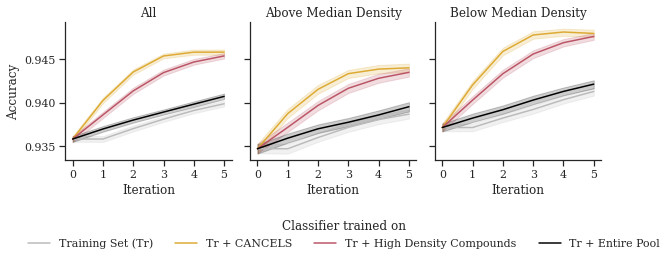

In [198]:
sns.set_style("ticks")
plt.rc('font', family='serif')
col_dict = {'Training Set (Tr)': COLORS['tr'], 'Tr + CANCELS': COLORS['imi'], 
            'Tr + High Density Compounds': COLORS['bias'], 'Tr + Entire Pool': COLORS['val']}
fig = sns.relplot(data=df_acc.append(df_tmp).reset_index(), x='Iteration', y='Accuracy', hue='Classifier trained on', 
                  col='Density', kind='line', palette=col_dict,
                  height=3, aspect=9/3 / 3)
fig.set_titles("{col_name}")
#sns.set(rc={'figure.figsize':(12/3/2.54,5/2.54)})
for axis in fig.axes[0]:
    axis.set_xticks([0, 1, 2, 3, 4, 5])
sns.move_legend(fig, 'upper center', bbox_to_anchor=(0.445, 0), ncol=4, prop={'family':'serif'})
fig.savefig('Plots/IterativeCANCELS_acc5.pdf', bbox_inches='tight')

In [208]:
# df_num = df_num.append(pd.DataFrame([[0,0,0,0,0,0,0,'Added Compounds (CANCELS)', 0]], columns=df_num.columns))
# df_num = df_num.append(pd.DataFrame([[0,0,0,0,0,0,0,'Available Compounds', 0]], columns=df_num.columns))

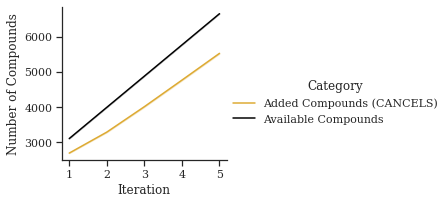

In [211]:
sns.set_style("ticks")
plt.rc('font', family='serif')
col_dict = {'Added Compounds (CANCELS)': COLORS['imi'], 'Available Compounds': COLORS['val']}
fig = sns.relplot(data=df_num.reset_index(), x='Iteration', y='Number of Compounds', hue='Category',
           kind='line', palette=col_dict, height=3, aspect=4 / 3)
for axis in fig.axes[0]:
    axis.set_xticks([1, 2, 3, 4, 5])
fig.savefig('Plots/IterativeCANCELS_num_points5.pdf', bbox_inches='tight')

# Experiment: Effect of the Number of PCs

In [20]:
def run_exp_nPC(data, labels, 
            test_size=0.2, val_size=0.2, 
            batchsize=10, num_restarts=3, 
            num_ica=[5], repeat=100,
            boundaries=True, strength=1000):

    for r in range(repeat):
        tr, test, idcs_tr, idcs_test = train_test_split(data, np.arange(len(data)), test_size=test_size)
        tr, val, idcs_tr, idcs_val = train_test_split(tr, idcs_tr, test_size=val_size)
        
        with open('Results\\Tox_NPC_it_'+str(r)+'.txt', 'w') as the_file:
            the_file.write('n_pc,acc\n')
        
        for i,p in enumerate(num_ica):
            # train ica, split data, train Imitate
            ica = FastICA(n_components = p)
            ica.fit(tr)
            d = ica.transform(tr)

            bounds_trf = np.vstack((d.min(axis=0), d.max(axis=0))).transpose()
            range_trf = bounds_trf[:,1] - bounds_trf[:,0]
            bounds_relaxed = np.vstack((bounds_trf[:,0]-0.1*range_trf, bounds_trf[:,1]+0.1*range_trf)).transpose()
            grids, vals, fitted, fill_up, num_fill_up, scale, mean, cov = Imitate(d, plots=False, bounds=bounds_relaxed, strength=strength)

            # select leftout points that improve the bias
            score = mimic_score(ica.transform(val), grids, vals, fitted, fill_up, vals_only=False)
            score = score / np.sum(score)  #convert to probability distribution

            idcs = add_points(d, grids, fitted, num_fill_up, score, ica.transform(val), 
                              batchsize=batchsize, num_restarts=num_restarts)

            X_plus, Y_plus = data[np.append(idcs_tr, idcs)], labels[np.append(idcs_tr, idcs)]
            X_test, Y_test = data[idcs_test], labels[idcs_test]

            # Classifier Chains
            cc = EnsembleClassifierChain(SVC(probability=True))
            cc.fit(X_plus, Y_plus)
            acc = hamming_accuracy(Y_test, cc.predict(X_test))

            with open('Results\\Tox_NPC_it_'+str(r)+'.txt', 'a') as the_file:
                the_file.write(str(p)+','+str(acc)+'\n')
            print('Completed', "{:.2f}".format((r*len(num_ica)+i)/(repeat*len(num_ica))), '%', end='\r')

In [23]:
run_exp_nPC(tox_X, tox_Y, test_size=0.4, val_size=0.4, num_ica=[2,3,5,8,13,21], repeat=100)

C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [188]:
files = glob.glob('Results\\Tox_NPC*')
li = []
for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)
df.columns = ['Number of PCs', 'Accuracy']
df = df.astype({df.columns[0]: 'int', df.columns[1]: 'float'})

df['Classifier Trained On'] = 'Tr + CANCELS'
df_tmp = pd.DataFrame()
r = res_tox_new_ecc[0][:,0]
df_tmp[df.columns[0]] = [2,3,5,8,13,21]*len(r)
df_tmp[df.columns[1]] = np.repeat(r, 6)
df_tmp[df.columns[2]] = 'Training Set (Tr)'
df = df.append(df_tmp, ignore_index=True)

r = res_tox_new_ecc[0][:,3]
df_tmp[df.columns[0]] = [2,3,5,8,13,21]*len(r)
df_tmp[df.columns[1]] = np.repeat(r, 6)
df_tmp[df.columns[2]] = 'Tr + Entire Pool'
df = df.append(df_tmp, ignore_index=True)

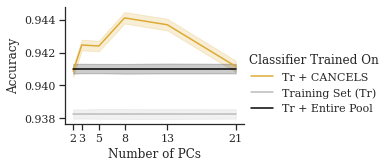

In [190]:
sns.set_style("ticks")
plt.rc('font', family='serif')
col_dict = {'Training Set (Tr)': COLORS['tr'], 'Tr + CANCELS': COLORS['imi'], 
            'Tr + High Density Points': COLORS['bias'], 'Tr + Entire Pool': COLORS['val']}
fig = sns.relplot(data=df, x='Number of PCs', y='Accuracy', hue='Classifier Trained On',
           kind='line', height=2.5, aspect=4 / 2.5, palette=col_dict)
for axis in fig.axes[0]:
    axis.set_xticks([2,3,5,8,13,21])
fig.savefig('Plots/NPC.pdf', bbox_inches='tight')

# Effect of other descriptors

In [5]:
# MACCS
df = pd.read_csv('Data/Tox21_MACCS.csv', header=0, low_memory=False)
d = df.replace('?', np.nan).astype(float).to_numpy()
tox_X_maccs, tox_Y_maccs = d[:,['y' not in col for col in df.columns]], d[:,['y' in col for col in df.columns]]

In [23]:
# PaDEL
df = pd.read_csv('Data/Tox21/dataset_padel.csv', header=0, low_memory=False)
tox_X_padel = df[df.columns[14:]].to_numpy()

In [58]:
# CDDD
df = pd.read_csv('Data/Tox21/dataset_cddd.csv', header=0, low_memory=False)
tox_X_cddd = df[df.columns[14:]].to_numpy()

# spectro
df = pd.read_csv('Data/Tox21/dataset_spectro.csv', header=0, low_memory=False)
tox_X_spectro = df[df.columns[14:]].to_numpy()

# vec
df = pd.read_csv('Data/Tox21/dataset_vec.csv', header=0, low_memory=False)
tox_X_vec = df[df.columns[14:]].to_numpy()

In [66]:
ica = FastICA(n_components=5)
tox_X_maccs_trf = ica.fit_transform(tox_X_maccs)
tox_X_padel_trf = ica.fit_transform(tox_X_padel)
tox_X_cddd_trf = ica.fit_transform(tox_X_cddd)
tox_X_spectro_trf = ica.fit_transform(tox_X_spectro)
tox_X_vec_trf = ica.fit_transform(tox_X_vec)

In [25]:
def bound_and_score(data):
    bounds_trf = np.vstack((data.min(axis=0), data.max(axis=0))).transpose()
    range_trf = bounds_trf[:,1] - bounds_trf[:,0]
    bounds_relaxed = np.vstack((bounds_trf[:,0]-0.1*range_trf, bounds_trf[:,1]+0.1*range_trf)).transpose()
    grids, vals, fitted, fill_up, num_fill_up, scale, mean, cov = Imitate(data, plots=False, bounds=bounds_relaxed, strength=1000)

    return mimic_score(data, grids, vals, fitted, fill_up, vals_only=False)

In [67]:
scores_maccs = bound_and_score(tox_X_maccs_trf)
#scores_padel = bound_and_score(tox_X_padel_trf)
scores_cddd = bound_and_score(tox_X_cddd_trf)
scores_spectro = bound_and_score(tox_X_spectro_trf)
scores_vec = bound_and_score(tox_X_vec_trf)

In [68]:
o = np.argsort(scores_maccs)

#### The order of scores resulting from different feature representations is not consistent. Further testing is required.

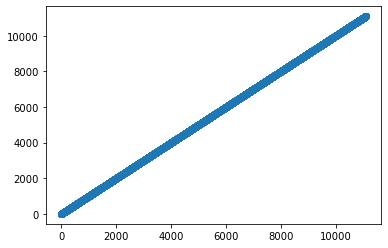

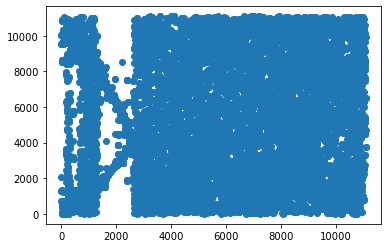

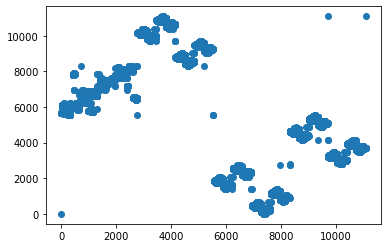

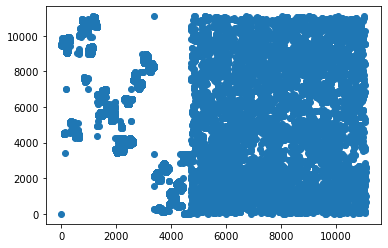

In [69]:
plt.scatter(np.argsort(scores_maccs[o]), np.argsort(scores_maccs[o]))
plt.show()

plt.scatter(np.argsort(scores_maccs[o]), np.argsort(scores_cddd[o]))
plt.show()

plt.scatter(np.argsort(scores_maccs[o]), np.argsort(scores_spectro[o]))
plt.show()

plt.scatter(np.argsort(scores_maccs[o]), np.argsort(scores_vec[o]))
plt.show()

#### PaDEL doesn't work because it is extremely zero-focussed after PCA. That means that the initial spread of the data in PaDEL representation was very low for all dimensions. We omit PaDEL from the tests.

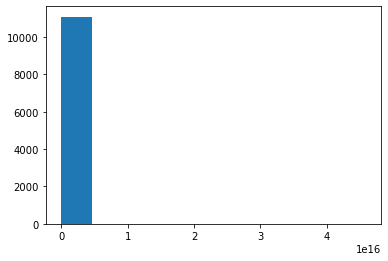

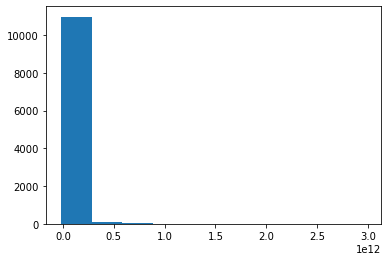

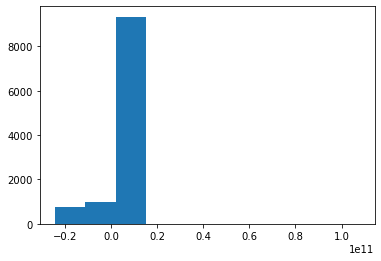

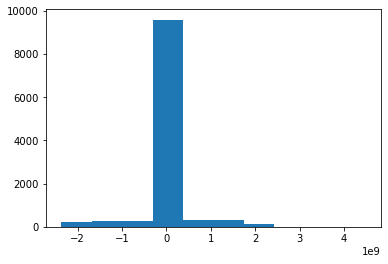

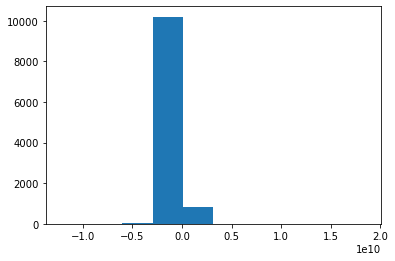

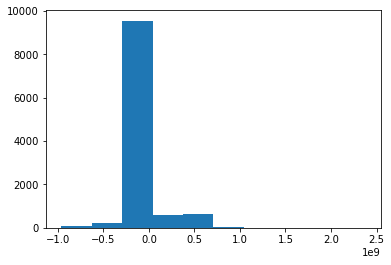

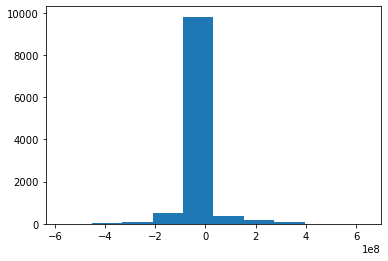

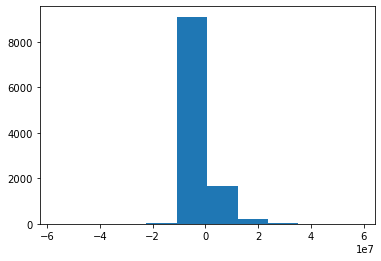

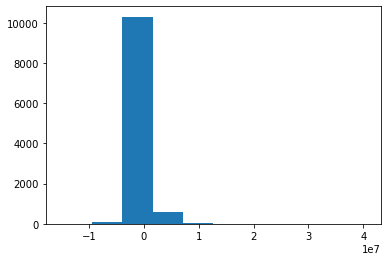

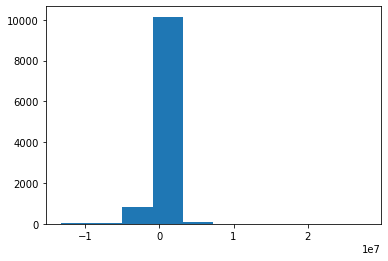

In [53]:
pca = PCA(n_components=10)
data = pca.fit_transform(tox_X_padel)
for dim in range(len(data[0])):
    plt.hist(data[:,dim])
    plt.show()

In [87]:
def run_exp_repr(representations, data_maccs, labels, 
            test_size=0.2, val_size=0.2, 
            batchsize=10, num_restarts=3, 
            num_ica=5, repeat=100,
            boundaries=True, strength=1000):

    for i,rep in enumerate(representations):
        
        if rep=='maccs': 
            data = data_maccs
        else: 
            df = pd.read_csv('Data/Tox21/dataset_'+rep+'.csv', header=0, low_memory=False)
            data = df[df.columns[14:]].to_numpy()
        
        for r in range(repeat):
                
            tr, test, idcs_tr, idcs_test = train_test_split(data, np.arange(len(data)), test_size=test_size)
            tr, val, idcs_tr, idcs_val = train_test_split(tr, idcs_tr, test_size=val_size)
            X_test, Y_test = data_maccs[idcs_test], labels[idcs_test]

            with open('Results\\Tox_REPR_'+rep+'_it_'+str(r)+'.txt', 'w') as the_file:
                the_file.write('Representation,Accuracy\n')

            # train ica, split data, train Imitate
            ica = FastICA(n_components = num_ica)
            ica.fit(tr)
            d = ica.transform(tr)

            bounds_trf = np.vstack((d.min(axis=0), d.max(axis=0))).transpose()
            range_trf = bounds_trf[:,1] - bounds_trf[:,0]
            bounds_relaxed = np.vstack((bounds_trf[:,0]-0.1*range_trf, bounds_trf[:,1]+0.1*range_trf)).transpose()
            grids, vals, fitted, fill_up, num_fill_up, scale, mean, cov = Imitate(d, plots=False, bounds=bounds_relaxed, strength=strength)

            # select leftout points that improve the bias
            score = mimic_score(ica.transform(val), grids, vals, fitted, fill_up, vals_only=False)
            if np.sum(score) == 0 or np.isnan(score).any(): 
                X_plus, Y_plus = data_maccs[idcs_tr], labels[idcs_tr]
            else:
                score = score / np.sum(score)  #convert to probability distribution

                idcs = add_points(d, grids, fitted, num_fill_up, score, ica.transform(val), 
                                  batchsize=batchsize, num_restarts=num_restarts)

                X_plus, Y_plus = data_maccs[np.append(idcs_tr, idcs)], labels[np.append(idcs_tr, idcs)]

            # Classifier Chains
            cc = EnsembleClassifierChain(SVC(probability=True))
            cc.fit(X_plus, Y_plus)
            acc = hamming_accuracy(Y_test, cc.predict(X_test))

            with open('Results\\Tox_REPR_'+rep+'_it_'+str(r)+'.txt', 'a') as the_file:
                the_file.write(rep+','+str(acc)+'\n')
                
            print('Completed', "{:.2f}".format(100*(i*repeat+r)/(repeat*len(representations))), '%', end='\r')

In [88]:
run_exp_repr(['padel', 'cddd', 'spectro', 'vec', 'maccs'], tox_X_maccs, tox_Y, test_size=0.4, val_size=0.4, repeat=100)

C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


C:\Users\Behzad\.conda\envs\my-rdkit-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [186]:
files = glob.glob('Results\\Tox_REPR*')
li = []
for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

In [187]:
df['Representation'].replace({'cddd': 'CDDD', 'maccs': 'MACCS', 'padel': 'PaDEL', 'spectro': 'Spectrophores', 'vec': 'Mol2vec'},
                            inplace=True)
repr_colors = {'CDDD': COLORS['tr'], 'MACCS': COLORS['imi'], 'PaDEL': COLORS['tr'], 'Spectrophores': COLORS['tr'], 'Mol2vec': COLORS['tr']}

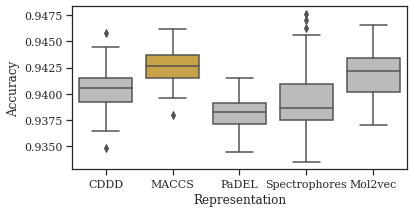

In [114]:
sns.set_style("ticks")
plt.rc('font', family='serif')
sns.boxplot(x='Representation', y='Accuracy', data=df, palette=repr_colors)
sns.set(rc={'figure.figsize':(6,2.5)})
plt.savefig('Plots/Representations.pdf', bbox_inches='tight')